## Scattering parameters for potassium-40

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys, os
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent))

from amo.constants import *


Define the 3D scattering parameters for $M_L = \pm 1$ (198.3 G) and $M_L = 0$ (198.8 G) resonances. Uses the effective range form from DJM Ahmed-Braun, et al (2021).

In [2]:
from functools import partial
from amo.resonant_scattering import *

V3D = partial(scattering_volume, B0=B0_77_pm1, DeltaB=DeltaB_77_pm1, Vbg=Vbg_77_pm1)  # Functions of B.
inv_R3D = lambda B: inverse_effective_range(V3D(B), R0=R0_77_pm1, Vbg=Vbg_77_pm1)  # Function of V.

V3D_m0 = partial(scattering_volume, B0=B0_77_0, DeltaB=DeltaB_77_0, Vbg=Vbg_77_0)  # Functions of B.
inv_R3D_m0 = lambda B: inverse_effective_range(V3D_m0(B), R0=R0_77_0, Vbg=Vbg_77_0)  # Function of V.

Eb3D = lambda B: pwave_bound_state_energy(V3D(B), inv_R3D(B))
Eb3D_m0 = lambda B: pwave_bound_state_energy(V3D_m0(B), inv_R3D_m0(B))

Plot the 3D scattering parameters

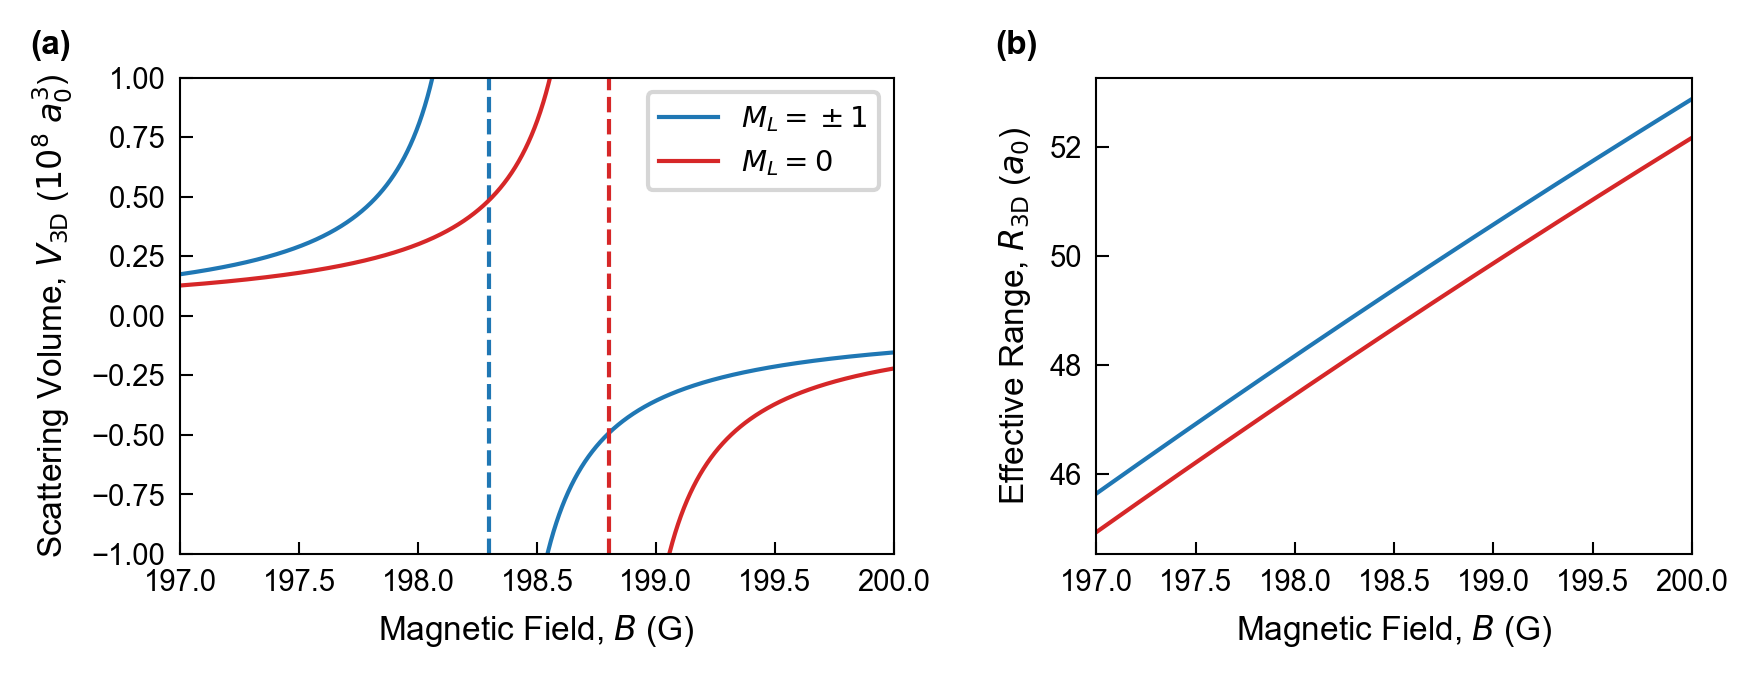

In [44]:
from general.plot_settings import colors, figsize, paper_settings, generate_plt_styles

plt.rcParams.update(paper_settings)
figsize = (6, 2.25)
fig, axs = plt.subplots(1, 2, figsize=figsize)

num = 1000
delta = 0.01
Bmin = 197
Bmax = 200
B = np.linspace(Bmin, Bmax, num)  # G
B_V = [np.linspace(Bmin, B0_77_pm1 - delta, num), 
                 np.linspace(B0_77_pm1 + delta, Bmax, num)]
B_V_m0 = [np.linspace(Bmin, B0_77_0 - delta, num), 
                 np.linspace(B0_77_0 + delta, Bmax, num)]

ax = axs[0]
ymin = -1
ymax = 1
ax.set(ylabel=r"Scattering Volume, $V_\mathrm{3D}$ ($10^8$ $a_0^3$)", xlabel=r"Magnetic Field, $B$ (G)")

ax.plot(B_V[0], V3D(B_V[0])/a_0**3 / 1e8, '-', label=r"$M_L=\pm 1$", color=colors[0])
ax.plot(B_V[1], V3D(B_V[1])/a_0**3 / 1e8, '-', color=colors[0])
ax.vlines(B0_77_pm1, ymin, ymax, colors=colors[0], linestyles='--')

ax.plot(B_V_m0[0], V3D_m0(B_V_m0[0])/a_0**3 / 1e8, '-', label=r"$M_L=0$", color=colors[3])
ax.plot(B_V_m0[1], V3D_m0(B_V_m0[1])/a_0**3 / 1e8, '-', color=colors[3])
ax.vlines(B0_77_0, ymin, ymax, colors=colors[3], linestyles='--')

ax.set_ylim(ymin, ymax)
ax.legend(loc="upper right", fontsize=7)

ax = axs[1]
ax.set(ylabel=r"Effective Range, $R_\mathrm{3D}$ ($a_0$)", xlabel=r"Magnetic Field, $B$ (G)")
ax.set_box_aspect(0.8)
ax.plot(B, 1/inv_R3D(B)/a_0, '-', label=r"$M_L=\pm 1$", color=colors[0])
ax.plot(B, 1/inv_R3D_m0(B)/a_0, '-', label=r"$M_L=0$", color=colors[3])

# ax.legend(fontsize=8, loc="upper left")

fig.tight_layout()  # Note this is done before the labels on purpose.
subplot_labels = ['(a)', '(b)']
x_offsets = [-0.21, -0.17]
for ax, label, x_offset in zip(axs, subplot_labels, x_offsets):
	ax.text(x_offset, 1.05, label, transform=ax.transAxes, fontweight='bold', fontsize=8)
	ax.set(xlim=(Bmin, Bmax))
	
plt.subplots_adjust(top=0.90)

fig.savefig("outputs/pwave_scattering_parameters.pdf")

plt.show()

## Quasi-one-dimensional scattering

Define the q1d scattering parameters and amplitudes. 

In [4]:
from amo.quantum_gas import oscillator_length
from scipy.optimize import root_scalar

omega_perp = 2 * pi * 100e3  # 100 kHz
a_osc = oscillator_length(omega_perp) * np.sqrt(2)  # Reduced mass.

inv_a_odd = lambda B: q1d_inverse_odd_scattering_length(V3D(B), inv_R3D(B), a_osc)
r_odd = lambda B: q1d_odd_effective_range(inv_R3D(B), a_osc)

f_odd = lambda Ek, B: 1/q1d_inverse_odd_scattering_amplitude(np.sqrt(mK * Ek) / hbar, 
                                                           inv_a_odd(B), r_odd(B))


a_even = lambda B: q1d_even_scattering_length(V3D(B), inv_R3D(B), a_osc)
r_even = lambda B: q1d_even_effective_range(inv_R3D(B), a_osc)

f_even = lambda Ek, B: 1/q1d_inverse_even_scattering_amplitude(np.sqrt(mK * Ek) / hbar, 
                                                           a_even(B), r_even(B))

a_even_m0 = lambda B: q1d_even_scattering_length(V3D_m0(B), inv_R3D_m0(B), a_osc)
r_even_m0 = lambda B: q1d_even_effective_range(inv_R3D_m0(B), a_osc)

f_even_m0 = lambda Ek, B: 1/q1d_inverse_even_scattering_amplitude(np.sqrt(mK * Ek) / hbar, 
                                                           a_even_m0(B), r_even_m0(B))


def q1d_resonant_field(resonance_zero, B_guess=199.0):
    root_results = root_scalar(resonance_zero, x0=B_guess, x1=B_guess+1.0)
    return root_results.root


B_res_odd = q1d_resonant_field(inv_a_odd)
print(f"Odd-wave resonance at B = {B_res_odd:.3f} G")

B_res_even = q1d_resonant_field(a_even)
print(f"Even-wave x resonance at B = {B_res_even:.3f} G")

B_res_even_m0 = q1d_resonant_field(a_even_m0)
print(f"Even-wave z resonance at B =" + f" {B_res_even_m0:.3f} G")

Odd-wave resonance at B = 198.874 G
Even-wave x resonance at B = 199.293 G
Even-wave z resonance at B = 199.821 G


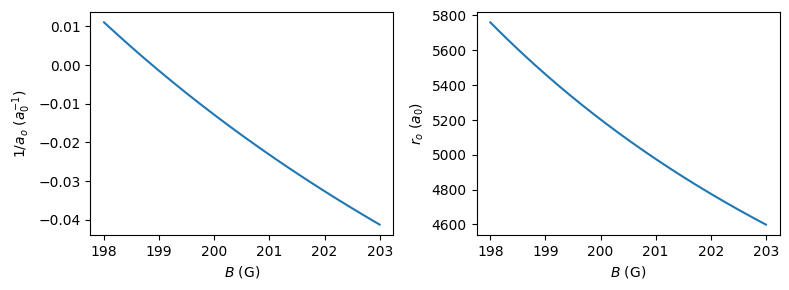

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

num = 1000
B = np.linspace(198, 203, 1000)  # G

ax = axs[0]
ax.set(ylabel=r"$1/a_o$ ($a_0^{-1}$)", xlabel=r"$B$ (G)")
ax.plot(B, a_0*inv_a_odd(B))
# ax.set_ylim(-3e2**3, 3e2**3)
# ax.legend(fontsize=8, loc="upper left")

ax = axs[1]
ax.set(ylabel=r"$r_o$ ($a_0$)", xlabel=r"$B$ (G)")
ax.plot(B, r_odd(B)/a_0)
# ax.plot(B, a_0/inv_R3D(B))
# ax.legend(fontsize=8, loc="upper left")

fig.tight_layout()
# fig.savefig("breit_rabi.png", dpi=300)
plt.show()

### Plotting scattering amplitudes
Plot the quasi-one-dimensional scattering amplitudes like in Jackson et al. 2023 Fig. 3.

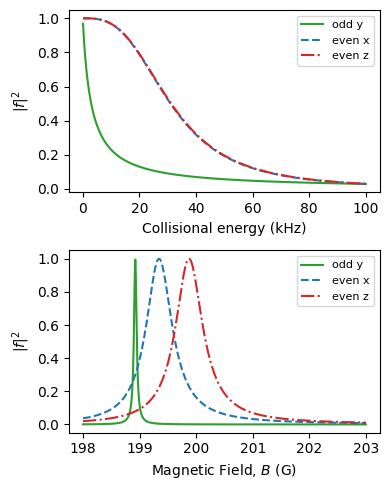

In [6]:
colour_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

colors = [colour_list[i] for i in [2, 0, 3]]

fig, axs = plt.subplots(2, 1, figsize=(4, 5))
num = 1000
B = np.linspace(198, 203, num)  # G
Ek = np.linspace(0.1, 100, num)  # kHz
Ek_typ = 10.0  # kHz

ax = axs[0]
ax.set(ylabel=r"$|f|^2$", xlabel=r"Collisional energy (kHz)")

ax.plot(Ek, np.abs(f_odd(Ek*h*1e3, B_res_odd))**2, '-',
        color=colors[0], label="odd y")
ax.plot(Ek, np.abs(f_even(Ek*h*1e3, B_res_even))**2, '--',
        color=colors[1], label="even x")
ax.plot(Ek, np.abs(f_even_m0(Ek*h*1e3, B_res_even_m0))**2, '-.',
        color=colors[2], label="even z")

ax.legend(fontsize=8, loc="upper right")

ax = axs[1]
ax.set(ylabel=r"$|f|^2$", xlabel=r"Magnetic Field, $B$ (G)")
ax.plot(B, np.abs(f_odd(Ek_typ*h*1e3, B))**2, '-',
        color=colors[0], label="odd y")
ax.plot(B, np.abs(f_even(Ek_typ*h*1e3, B))**2, '--',
        color=colors[1], label="even x")
ax.plot(B, np.abs(f_even_m0(Ek_typ*h*1e3, B))**2, '-.',
        color=colors[2], label="even z")

ax.legend(fontsize=8, loc="upper right")


fig.tight_layout()
# fig.savefig("q1d_scattering_ampitude.png", dpi=300)
plt.show()

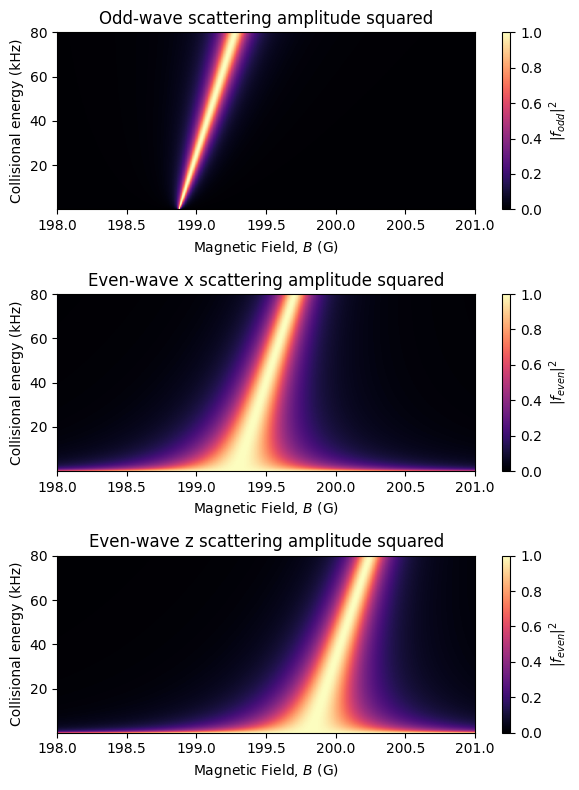

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(6, 8))
num = 1000
B = np.linspace(198, 201, num)  # G
Ek = np.linspace(0.1, 80, num)  # kHz

cmap = 'magma'

# Colormap of |f|^2 across (Ek, B) grid
def plot_2d_colormap(ax, x, y, Z, xlabel="", ylabel="", title="", colorbar_label=""):
    im = ax.pcolormesh(x, y, Z, shading='auto', cmap=cmap, 
                       norm=plt.Normalize(vmin=0, vmax=1.0))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(colorbar_label)


Z_odd = np.abs(f_odd(Ek[:, None]*h*1e3, B[None, :]))**2
plot_2d_colormap(axs[0], B, Ek, Z_odd,
                  xlabel=r"Magnetic Field, $B$ (G)",
                  ylabel=r"Collisional energy (kHz)",
                  title="Odd-wave scattering amplitude squared",
                  colorbar_label=r"$|f_{odd}|^2$")

Z_even = np.abs(f_even(Ek[:, None]*h*1e3, B[None, :]))**2
plot_2d_colormap(axs[1], B, Ek, Z_even,
                xlabel=r"Magnetic Field, $B$ (G)",
                ylabel=r"Collisional energy (kHz)",
                title="Even-wave x scattering amplitude squared",
                colorbar_label=r"$|f_{even}|^2$")

Z_even_m0 = np.abs(f_even_m0(Ek[:, None]*h*1e3, B[None, :]))**2
plot_2d_colormap(axs[2], B, Ek, Z_even_m0,
                 xlabel=r"Magnetic Field, $B$ (G)",
                ylabel=r"Collisional energy (kHz)",
                title="Even-wave z scattering amplitude squared",
                colorbar_label=r"$|f_{even}|^2$")

fig.tight_layout()
plt.show()

## Quasi-two-dimensional scattering z-confinement

In [ ]:
from amo.quantum_gas import oscillator_length
from scipy.optimize import root_scalar

omega_perp = 2 * pi * 100e3  # 100 kHz
a_osc = oscillator_length(omega_perp) * np.sqrt(2)  # Reduced mass.

inv_a_p = lambda B: q2d_inverse_pwave_scattering_area(V3D(B), inv_R3D(B), a_osc)
ln_inv_r_p = lambda B: q2d_pwave_ln_inverse_effective_range(inv_R3D(B), a_osc)

ln_a_s_sq = lambda B: q2d_swave_ln_scattering_length_squared(V3D_m0(B), inv_R3D_m0(B), a_osc)
r_s = lambda B: q2d_swave_effective_range(inv_R3D_m0(B), a_osc)


def q2d_reference_field(mL, B_guess=199.0):
    E_shift = (1/2 + mL) * hbar * omega_perp

    if mL == 0:
        zero_func = lambda B: Eb3D(B) + E_shift
    elif mL == 1:  # Use mL=0 res for s-wave case, since z-confinement
        zero_func = lambda B: Eb3D_m0(B) + E_shift 
    else:
        raise ValueError("ell must be 0 or 1.")
    
    root_results = root_scalar(zero_func, x0=B_guess, x1=B_guess+1.0)
    return root_results.root


B_ref_p = q2d_reference_field(0)
print(f"q2D p-wave resonance at B = {B_ref_p:.3f} G")

B_ref_s = q2d_reference_field(1)
print(f"q2D s-wave resonance at B = {B_ref_s:.3f} G")

q2D p-wave resonance at B = 198.574 G
q2D s-wave resonance at B = 199.647 G
